# 0. Introduction

While the previous projects dealt with medical image features, we turn now to the classification of entire time series into one of 4 classes. This time you will work with the original ECG recordings of different length sampled as 300Hz to predict heart rhythm.

X_train.csv: the training signals, each row is one sample indexed by an id, the first column contains the id, and the rest columns are up to 17842 sample points.

X_test.csv: the test set, same structure

y_train.csv: the training targets (signal classes)

The problem was a classification task. We had ECG measurements of 4 classes that were unbalanced and of not the same length. We used different techinques to extract features that we used for the classification. For each ECG signal we extracted the autocorrelation, the average and the power. We also extracted 15 coefficients of the FFT. For each ECG using biosspy we extracted the heartbeats, averaged them and created a characteristic average of the same length of each patient. For each of these signals (after normalization) we extracted the energy of the wave, the T, S, P, R, Q peaks, the ST QRS PR intervals, QRS/T and QRS/P ratios, the median, mean and interval of the amplitude and the db2 coefficients. Finally, the library biosspy gave us the locations of peaks in the original wave, the timings as well as the heart beats and their timings. For all of them we calculated the mean, median and standard deviation. We also extracted the mean, median and standard deviation of the differences between the peaks' timings( important feature to classify noise, normal heart rate and abnormal heart rhythms). Using all of these features we trained a GradientBoosting model which was fine-tuned using a Cross-validation grid search. The model has 0.817 mean score in the cross-validation and 0.833 in the public scoreboard.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import csv
import os

import biosppy as biosppy
import biosppy.signals.ecg as ecg
import pywt

from sklearn.preprocessing import normalize
from scipy import stats
from statistics import pstdev,variance

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer

# 1. Preprocessing

## 1.0 Read data from CSV files

Use pandas to read csv file. Then discard unnecessary columns (id column). Check the correctness of data reading in the end of the cell.

In [2]:
x_train = pd.read_csv("task2/X_train.csv")
y_train = pd.read_csv("task2/y_train.csv")
x_test = pd.read_csv("task2/X_test.csv")

x_train.pop("id")
y_train.pop("id")
x_test.pop("id")

x_train.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,505,500,496,492,487,480,475,476,483,495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-21,-16,-12,-7,-3,0,1,2,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(x_train.shape, x_test.shape, y_train.shape)

(5117, 17842) (3411, 17842) (5117, 1)


## 1.1 Extract frequency domain features

In [4]:
# extract frequency domain features: FFT, power, average and autocorrelation
# before padding to 9000 points
autocorr = []
ptp = []
avg = []
fft = []

for i in range(len(x_train)):
    # extract i-th single row as a dataframe and drop na values
    signal = x_train.loc[i].dropna().to_numpy(dtype='float32')
    signal_series = pd.Series(signal)
    # extract autocorrelation, average, ptp(max-min)
    autocorr.append(signal_series.autocorr(lag=2))
    avg.append(np.average(signal))
    ptp.append(np.ptp(signal))
    f_coefficients = np.fft.fft(signal)
    f_coefficients = f_coefficients[0:800]
    n = 15
    f = f_coefficients.argsort()[-n:][::-1]
    fft.append(f)
     
autocorr = np.transpose(np.array([autocorr]))
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft = np.array(fft)

## 1.2 Time Series Analysis using Biosppy

In [5]:
# function for extracting average of squared rpeaks differences
def mean_sqrd_diff(rpeaks):
    diff = np.diff(rpeaks)
    mean_sqrd = np.mean(diff*diff)
    return mean_sqrd

In [6]:
# Process a raw ECG signal and extract relevant signal features using default parameters
# return ts, filtered, rpeaks, templates_ts, heartbeat templates
# and heart_rate_ts, heart_rate
ts_list = []
filtered_list = []
rpeaks_list = []
templates_ts_list = []
templates_list = []
heart_rate_ts_list = []
heart_rate_list = []

for i in range(len(x_train)):
# print(i)
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = \
        biosppy.signals.ecg.ecg(signal = x_train.loc[i].dropna().to_numpy(dtype='float32'),
                                sampling_rate=300.0, show=False)

# # Correct R-peak locations to the maximum, introduce some tolerance level
#     rpeaks = ecg.correct_rpeaks(signal = x_train.loc[i].dropna().to_numpy(dtype='float32'),
#                                 rpeaks = rpeaks, sampling_rate = 300.0,
#                                 tol = 0.01)  
# # Set heart rates to array of nans if contains no elements, otherwise min and max are not defined
#     if len(heart_rate) == 0:
#         heart_rate = np.array([np.nan, np.nan])
#     if len(heart_rate_ts) == 0:
#         heart_rate_ts = np.array([np.nan, np.nan])
        
    filtered_list.append(filtered)
    rpeaks_list.append(rpeaks)
    templates_ts_list.append(templates_ts)
    templates_list.append(templates)
    heart_rate_ts_list.append(heart_rate_ts)
    heart_rate_list.append(heart_rate)
    ts_list.append(ts)

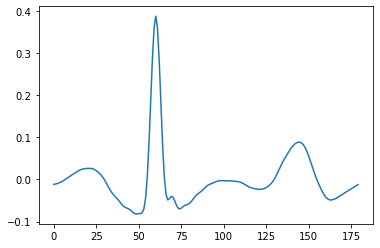

In [7]:
# Find the average characteristic heartbeat and try to plot one sample
normalized_templates = []
average_heartbeats = []
for i in range(len(templates_list)):
    normalized_templates.append(normalize(templates_list[i]))
    average_heartbeats.append(sum(normalized_templates[i])/len(normalized_templates[i]))
    
plt.plot(average_heartbeats[0])
plt.show()

In [8]:
# Find P,Q,R,S,T
P_list = []
Q_list = []
R_list = []
S_list = []
T_list = []

P_value_list = []
Q_value_list = []
S_value_list = []
T_value_list = []

def find_points(i):
    current = average_heartbeats[i]
    # Find R(the peak)
    sample_point = np.where(current == max(current))
    R = sample_point[0]
    
    first_half = current[0:R[0]]
    sample_point = np.where(current == min(first_half[R[0]-30:R[0]]))
    Q = sample_point[0]
    
    sample_point = np.where(first_half[0:Q[0]] == max(first_half[0:Q[0]]))
    P = sample_point[0]
    
    second_half = current[R[0]+1:]
    sample_point = np.where(current == min(second_half[0:30]))
    S = sample_point[0]
    
    sample_point = np.where(current == max(second_half[(S[0]-R[0]+1):]))
    T = sample_point[0]
    
    return P,Q,R,S,T

# current = average_heartbeats[256]
# plt.plot(current)
# plt.scatter(find_points(256)[0],current[find_points(256)[0]],label='P')
# plt.scatter(find_points(256)[1],current[find_points(256)[1]],label='Q')
# plt.scatter(find_points(256)[2],current[find_points(256)[2]],label='R')
# plt.scatter(find_points(256)[3],current[find_points(256)[3]],label='S')
# plt.scatter(find_points(256)[4],current[find_points(256)[4]],label='T')
# plt.plot(np.arange(0, 180),np.zeros(180), 'r--') 
# plt.legend()
# plt.show()

In [9]:
for i in range(len(average_heartbeats)):
#     print(i)
    P_list.append(find_points(i)[0])
    Q_list.append(find_points(i)[1])
    R_list.append(find_points(i)[2])
    S_list.append(find_points(i)[3])
    T_list.append(find_points(i)[4])
    
    P_value_list.append(average_heartbeats[i][find_points(i)[0]])
    Q_value_list.append(average_heartbeats[i][find_points(i)[1]])
    S_value_list.append(average_heartbeats[i][find_points(i)[3]])
    T_value_list.append(average_heartbeats[i][find_points(i)[4]])

In [10]:
mean_sqrd = []
for i in range(len(rpeaks_list)):
    mean_sqrd.append(mean_sqrd_diff(rpeaks_list[i]))
len(mean_sqrd)

5117

In [11]:
# Find Intervals and Ratios of peaks
RR_list = []
PR_list = []
QRS_list = []
ST_list = []

def findInterval(i):
    if i+1 < len(R_list):
        RR_list.append(P_list[i+1]-P_list[i])
    PR_list.append(R_list[i]-P_list[i])
    QRS_list.append(S_list[i]-Q_list[i])
    ST_list.append(T_list[i]-S_list[i])
    
for i in range(len(P_list)):
    findInterval(i)

RR_list = np.array(RR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)

<ipython-input-11-046d8f0228d1>:26: RuntimeWarning: divide by zero encountered in true_divide
  QRS_P_list= np.divide(QRS_list, P_list)


In [12]:
max_wave = []
min_wave = []
mean_wave = []
median_wave = []

for i in range(len(average_heartbeats)):
    current = average_heartbeats[i]
    max_wave.append(max(current))
    min_wave.append(min(current))
    mean_wave.append(np.mean(current))
    median_wave.append(np.median(current))

In [13]:
# Heart rates mean, median, variant and standard deviation
hr_mean = []
hr_std = []
hr_median = []
hr_var = []

for i in range(len(heart_rate_list)):
    d = np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))
    
hr_mean=np.nan_to_num(hr_mean, nan = 0.0)
hr_std=np.nan_to_num(hr_std, nan = 0.0)
hr_median=np.nan_to_num(hr_median, nan = 0.0)
hr_var=np.nan_to_num(hr_var, nan = 0.0)

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWa

In [14]:
# Timings of peaks mean, median, variant and standard deviation
ts_mean = []
ts_std = []
ts_median = []
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)

In [15]:
# Timings of heart rates mean, median, variant and standard deviation
hr_ts_mean = []
hr_ts_std = []
hr_ts_median = []
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)

In [16]:
# Peaks mean, median, variant, mode and standard deviation
peaks_mean = []
peaks_std = []
peaks_median =  []
peaks_mode = []
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

In [17]:
# Peaks differences mean, median, variant, mode and standard deviation
diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []

for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)

In [18]:
# Energy of the signal
energy_list = []
for i in range(len(average_heartbeats)):
    energy_list.append(np.sum(average_heartbeats[i] ** 2))

In [19]:
# db2 coefficients
cA_list=[]
cD_list=[]

for i in range(len(average_heartbeats)):
    cA, cD = pywt.dwt(average_heartbeats[i], 'db2', mode='periodic')

    cA_list.append(cA)
    cD_list.append(cD)

In [20]:
# Prepare data
hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)

hr_ts_mean = np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std = np.array(hr_ts_std).reshape(-1,1)
hr_ts_median = np.array(hr_ts_median).reshape(-1,1)
hr_ts_var = np.array(hr_ts_var).reshape(-1,1)

ts_mean = np.array(ts_mean).reshape(-1,1)
ts_std = np.array(ts_std).reshape(-1,1)
ts_median = np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)

peaks_mean = np.array(peaks_mean).reshape(-1,1)
peaks_std = np.array(peaks_std).reshape(-1,1)
peaks_median = np.array(peaks_median).reshape(-1,1)
peaks_mode = np.array(peaks_mode).reshape(-1,1)
peaks_var = np.array(peaks_var).reshape(-1,1)

diff_mean = np.array(diff_mean).reshape(-1,1)
diff_std = np.array(diff_std).reshape(-1,1)
diff_median = np.array(diff_median).reshape(-1,1)
diff_mode = np.array(diff_mode).reshape(-1,1)
diff_var = np.array(diff_var).reshape(-1,1)
diff_dev = np.array(diff_dev).reshape(-1,1)

max_wave = np.array(max_wave).reshape(-1,1)
min_wave = np.array(min_wave).reshape(-1,1)
mean_wave = np.array(mean_wave).reshape(-1,1)
median_wave = np.array(median_wave).reshape(-1,1)

energy_list = np.array(energy_list).reshape(-1,1)
# RR_list = np.array(RR_list).reshape(-1,1)
PR_list = np.array(PR_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
Q_list = np.array(Q_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

mean_sqrd = np.array(mean_sqrd).reshape(-1,1)

# Creates array of all training data's features
feats_train = np.concatenate((fft,
                             autocorr,
                             ptp,
                             avg,
                             peaks_var,
                             peaks_mean,
                             peaks_std,
                             peaks_median,
                             peaks_mode,
                             P_list,
                             Q_list,
                             R_list,
                             S_list,
                             T_list,
                             ST_list,
                             QRS_list,
                             PR_list,
                             QRS_T_list,
                             max_wave - min_wave,
                             mean_wave,
                             median_wave,
                             hr_std,
                             hr_mean,
                             hr_std,
                             hr_var,
                             hr_median,
                             hr_ts_mean,
                             hr_ts_std,
                             hr_ts_median,
                             hr_ts_var,
                             diff_dev,
                             diff_var,
                             diff_std,
                             diff_mode,
                             diff_mean,
                             diff_median,
                             ts_mean,
                             ts_std,
                             ts_median,
                             ts_var,
                             mean_sqrd,
                             cD_list,
                             cA_list,
                             energy_list), axis=1)
print(feats_train.shape)

(5117, 238)


# 2. Classification using Gradient Boost Classifier

In [33]:
x_training = feats_train
y_train = np.ravel(y_train)

#replacing NaNs with median of columns
impute1 = SimpleImputer(strategy = 'median', fill_value = 0)
x_training = impute1.fit_transform(x_training)

#rescaling data
scaler = StandardScaler() 
scaler.fit(x_training)
x_train = scaler.transform(x_training)

# clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
#                                  min_samples_split=60, min_samples_leaf=9, subsample=1.0,
#                                  max_features=50, random_state=0)
# using best parameter given by GS
# max_features from 60 to 50
clf = GradientBoostingClassifier(n_estimators = 250, 
                                       max_depth = 5,
                                       learning_rate = 0.1, 
                                       max_features = 60)
scorer_f1 = make_scorer(f1_score, greater_is_better = True, average = 'micro')

cv_means = []
cv_stds = []

# changed to 5-fold
for i in np.arange(10):
    scores = cross_val_score(estimator = clf,
                                 X = x_training,
                                 y = y_train,
                                 scoring = scorer_f1,
                                 cv = KFold(n_splits = 5, shuffle = True))
    cv_means.append(np.mean(scores))
    cv_stds.append(np.std(scores))

print("Average of F1 scores:", np.mean(cv_means))
print("Standard deviation of F1 scores:", np.mean(cv_stds))

Average of F1 scores: 0.8098094796248778
Standard deviation of F1 scores: 0.00852296866798561


# 3. Extracting features from Test set

In [22]:
# extract frequency domain features: FFT, power, average and autocorrelation
# before padding to 9000 points
autocorr = []
ptp = []
avg = []
fft = []

for i in range(len(x_test)):
    # extract i-th single row as a dataframe and drop na values
    signal = x_test.loc[i].dropna().to_numpy(dtype='float32')
    signal_series = pd.Series(signal)
    # extract autocorrelation, average, ptp(max-min)
    autocorr.append(signal_series.autocorr(lag=2))
    avg.append(np.average(signal))
    ptp.append(np.ptp(signal))
    f_coefficients = np.fft.fft(signal)
    f_coefficients = f_coefficients[0:800]
    n = 15
    f = f_coefficients.argsort()[-n:][::-1]
    fft.append(f)
     
autocorr = np.transpose(np.array([autocorr]))
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft = np.array(fft)

In [23]:
# Process a raw ECG signal and extract relevant signal features using default parameters
# return ts, filtered, rpeaks, templates_ts, heartbeat templates
# and heart_rate_ts, heart_rate
ts_list = []
filtered_list = []
rpeaks_list = []
templates_ts_list = []
templates_list = []
heart_rate_ts_list = []
heart_rate_list = []

for i in range(len(x_test)):
# print(i)
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = \
        biosppy.signals.ecg.ecg(signal = x_test.loc[i].dropna().to_numpy(dtype='float32'),
                                sampling_rate=300.0, show=False)

# # Correct R-peak locations to the maximum, introduce some tolerance level
#     rpeaks = ecg.correct_rpeaks(signal = x_test.loc[i].dropna().to_numpy(dtype='float32'),
#                                 rpeaks = rpeaks, sampling_rate = 300.0,
#                                 tol = 0.01)  
# # Set heart rates to array of nans if contains no elements, otherwise min and max are not defined
#     if len(heart_rate) == 0:
#         heart_rate = np.array([np.nan, np.nan])
#     if len(heart_rate_ts) == 0:
#         heart_rate_ts = np.array([np.nan, np.nan])
        
    filtered_list.append(filtered)
    rpeaks_list.append(rpeaks)
    templates_ts_list.append(templates_ts)
    templates_list.append(templates)
    heart_rate_ts_list.append(heart_rate_ts)
    heart_rate_list.append(heart_rate)
    ts_list.append(ts)
    
# Find the average characteristic heartbeat
normalized_templates = []
average_heartbeats = []
for i in range(len(templates_list)):
    normalized_templates.append(normalize(templates_list[i]))
    average_heartbeats.append(sum(normalized_templates[i])/len(normalized_templates[i]))
    
# Find P,Q,R,S,T
P_list = []
Q_list = []
R_list = []
S_list = []
T_list = []

for i in range(len(average_heartbeats)):
    P_list.append(find_points(i)[0])
    Q_list.append(find_points(i)[1])
    R_list.append(find_points(i)[2])
    S_list.append(find_points(i)[3])
    T_list.append(find_points(i)[4])

mean_sqrd = []
for i in range(len(rpeaks_list)):
    mean_sqrd.append(mean_sqrd_diff(rpeaks_list[i]))

# Find Intervals and Ratios of peaks
RR_list = []
PR_list = []
QRS_list = []
ST_list = []
    
for i in range(len(P_list)):
    findInterval(i)

RR_list = np.array(RR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)

max_wave = []
min_wave = []
mean_wave = []
median_wave = []

for i in range(len(average_heartbeats)):
    current = average_heartbeats[i]
    max_wave.append(max(current))
    min_wave.append(min(current))
    mean_wave.append(np.mean(current))
    median_wave.append(np.median(current))

# Heart rates mean, median, variant and standard deviation
hr_mean = []
hr_std = []
hr_median = []
hr_var = []

for i in range(len(heart_rate_list)):
    d = np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))
    
hr_mean=np.nan_to_num(hr_mean, nan = 0.0)
hr_std=np.nan_to_num(hr_std, nan = 0.0)
hr_median=np.nan_to_num(hr_median, nan = 0.0)
hr_var=np.nan_to_num(hr_var, nan = 0.0)

# Timings of peaks mean, median, variant and standard deviation
ts_mean = []
ts_std = []
ts_median = []
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)

# Timings of heart rates mean, median, variant and standard deviation
hr_ts_mean = []
hr_ts_std = []
hr_ts_median = []
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)

# Peaks mean, median, variant, mode and standard deviation
peaks_mean = []
peaks_std = []
peaks_median =  []
peaks_mode = []
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

# Peaks differences mean, median, variant, mode and standard deviation
diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []

for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)

# db2 coefficients
cA_list=[]
cD_list=[]

for i in range(len(average_heartbeats)):
    cA, cD = pywt.dwt(average_heartbeats[i], 'db2', mode='periodic')

    cA_list.append(cA)
    cD_list.append(cD)

# Energy of the signal
energy_list = []
for i in range(len(average_heartbeats)):
    energy_list.append(np.sum(average_heartbeats[i] ** 2))

# Prepare data
hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)

hr_ts_mean = np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std = np.array(hr_ts_std).reshape(-1,1)
hr_ts_median = np.array(hr_ts_median).reshape(-1,1)
hr_ts_var = np.array(hr_ts_var).reshape(-1,1)

ts_mean = np.array(ts_mean).reshape(-1,1)
ts_std = np.array(ts_std).reshape(-1,1)
ts_median = np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)

peaks_mean = np.array(peaks_mean).reshape(-1,1)
peaks_std = np.array(peaks_std).reshape(-1,1)
peaks_median = np.array(peaks_median).reshape(-1,1)
peaks_mode = np.array(peaks_mode).reshape(-1,1)
peaks_var = np.array(peaks_var).reshape(-1,1)

diff_mean = np.array(diff_mean).reshape(-1,1)
diff_std = np.array(diff_std).reshape(-1,1)
diff_median = np.array(diff_median).reshape(-1,1)
diff_mode = np.array(diff_mode).reshape(-1,1)
diff_var = np.array(diff_var).reshape(-1,1)
diff_dev = np.array(diff_dev).reshape(-1,1)

max_wave = np.array(max_wave).reshape(-1,1)
min_wave = np.array(min_wave).reshape(-1,1)
mean_wave = np.array(mean_wave).reshape(-1,1)
median_wave = np.array(median_wave).reshape(-1,1)

energy_list = np.array(energy_list).reshape(-1,1)
# RR_list = np.array(RR_list).reshape(-1,1)
PR_list = np.array(PR_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
Q_list = np.array(Q_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

mean_sqrd = np.array(mean_sqrd).reshape(-1,1)

# Creates array of all testing data's features
feats_test = np.concatenate((fft,
                             autocorr,
                             ptp,
                             avg,
                             peaks_var,
                             peaks_mean,
                             peaks_std,
                             peaks_median,
                             peaks_mode,
                             P_list,
                             Q_list,
                             R_list,
                             S_list,
                             T_list,
                             ST_list,
                             QRS_list,
                             PR_list,
                             QRS_T_list,
                             max_wave - min_wave,
                             mean_wave,
                             median_wave,
                             hr_std,
                             hr_mean,
                             hr_std,
                             hr_var,
                             hr_median,
                             hr_ts_mean,
                             hr_ts_std,
                             hr_ts_median,
                             hr_ts_var,
                             diff_dev,
                             diff_var,
                             diff_std,
                             diff_mode,
                             diff_mean,
                             diff_median,
                             ts_mean,
                             ts_std,
                             ts_median,
                             ts_var,
                             mean_sqrd,
                             cD_list,
                             cA_list,
                             energy_list), axis=1)
print(feats_test.shape)

<ipython-input-23-6dabf44f86c3>:79: RuntimeWarning: divide by zero encountered in true_divide
  QRS_P_list= np.divide(QRS_list, P_list)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double

(3411, 238)


# 4. Write predictions to CSV

In [37]:
#replacing NaNs with median of columns
impute2 = SimpleImputer(strategy = 'median', fill_value = 0)
feats_test = impute2.fit_transform(feats_test)

#rescaling data
feats_test = scaler.transform(feats_test)

clf.fit(x_training, y_train)
predictions = clf.predict(feats_test)

prediction_results = pd.DataFrame(data = predictions, columns = ['y'])
index = [i for i in range(len(prediction_results))]
prediction_results.insert(0,"id",index)
prediction_results.to_csv('task2/result_10.csv',index = False)

In [38]:
prediction_results

,id,y
0,0,3
1,1,3
2,2,2
3,3,3
4,4,3
...,...,...
3406,3406,3
3407,3407,3
3408,3408,3
3409,3409,3
